In [152]:
import numpy as np
import matplotlib.pyplot as plt
from customer_behaviour.tools.dgm import DGM

dgm = DGM()

sample_length = 10000
n_experts = 10

def get_purchase_ratio(sequence):
    return np.count_nonzero(sequence)/len(sequence)

def get_purchase_amount(sequence):
    return np.sum(sequence)/np.count_nonzero(sequence)

def get_mean_std_purchase_frequency(seq, n_product_groups=1):
    seq = np.array(seq)
    if seq.ndim > 1:
        pass
    else:
        seq = np.reshape(seq, (1, seq.size))
    mean_frequencies = list()
    std_frequencies = list()
    # Find the indices of non-zero values in the time series
    indices = np.argwhere(seq)  # indices is a list of lists where each sublist is the index of a non-zero element (e.g. [i, j] if self.x is a matrix)
    for i in range(n_product_groups):
        # Calculate the distance between non-zero values
        tmp = np.diff(indices[np.where(indices[:,0] == i), 1])
        if tmp.size != 0:
            mean_frequencies.append(np.mean(tmp))
            std_frequencies.append(np.std(tmp))
        else:
            # The customer never buys (there are no non-zero elements in self.x)
            mean_frequencies.append(seq.shape[1])
            std_frequencies.append(seq.shape[1])
    return mean_frequencies, std_frequencies

def categorize_age(age):
    if age < 30: return 0
    elif 30 <= age < 40: return 1
    elif 40 <= age < 50: return 2
    elif 50 <= age < 60: return 3
    elif 60 <= age < 70: return 4
    elif 70 <= age: return 5

def normalize_features(features):
    # input should be list of lists where each list contains a n_expert values for a feature
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler() 
    scaler.fit(np.array(features).T)
    norm_features = scaler.transform(np.array(features).T).T
    return norm_features

def generate_data(n_experts, sample_length):
    samples = []
    freqs = []
    indices = []
    amounts = []
    sex = []
    ages = []
    features = []
    ratios = []
    std_freqs = []
    for i in range(n_experts):
        dgm.spawn_new_customer(i)
        sample = dgm.sample(sample_length)
        sample = np.sum(sample, axis=0)
        samples.append(sample)
        mean_freq, std_freq = get_mean_std_purchase_frequency(sample)
        freqs.append(mean_freq[0])
        std_freqs.append(std_freq[0])
        
        amounts.append(get_purchase_amount(sample))
        ratios.append(get_purchase_ratio(sample))
        sex.append(dgm.sex)
        ages.append(categorize_age(dgm.age))
    features.append(freqs)
    features.append(amounts)
    features.append(sex)
    features.append(ages)
    features.append(ratios)
    features.append(std_freqs)

    return samples, features

samples, features = generate_data(n_experts, sample_length)

In [ ]:
def reduce_dimensionality(val_states, max_n_purchases, keep_only_unique=False):
    '''
    val_states: [[v_{0}], [v_{1}], ..., [v_{n-2}], [v_{n-1}]]
    max_n_purchases: The maximum number of purchases that is allowed in a validation state
    '''
    indices = np.argwhere(np.sum(val_states, axis=1) > max_n_purchases)  # list of lists
    indices = [x[0] for x in indices]

    assert len(val_states) > 0
    n = len(val_states[0])
    substitute = n * [1]

    for i in indices:
        val_states[i] = substitute

    if keep_only_unique:
        temp = set(tuple(x) for x in val_states)
        return [list(x) for x in temp]
    else:
        return val_states

def get_cond_val_states(states, actions, n):
    n_trajectories = len(states)

    purchase = []
    no_purchase = []

    for i in range(n_trajectories):
        for temp_state, temp_action in zip(states[i], actions[i]):
            # Extract the last n days
            last_n_days = temp_state[-n:]
            val_state = [int(x) for x in last_n_days]
            # val_state.append(temp_action)
            if temp_action == 1:
                purchase.append(val_state)
            else:
                no_purchase.append(val_state)

    return purchase, no_purchase

def sort_possible_val_states(possible_val_states):
    temp = possible_val_states.copy()
    # temp.sort(key=lambda x: sum(x))
    # temp = np.array(temp)
    temp_splitted = []
    s = 0
    while sum(len(x) for x in temp_splitted) < len(temp):
        indices = np.argwhere(np.sum(temp, axis=1) == s)
        t = [temp[i[0]] for i in indices]
        t.sort(reverse=True)
        temp_splitted.append(t)
        s += 1
    return [item for sublist in temp_splitted for item in sublist]

def get_counts(observed_val_states, possible_val_states, normalize=False):
    counts = len(possible_val_states) * [0]
    for temp in observed_val_states:
        i = possible_val_states.index(temp)
        counts[i] += 1
    if normalize:
        counts = list(np.array(counts) / np.sum(counts))
    return counts


class Case22():  # dummy encoding (dynamic)
    def __init__(self, model, n_experts=None):
        self.model = model
        self.n_experts = n_experts

    def get_spaces(self, n_historical_events):
        observation_space = spaces.MultiBinary(self.n_experts + n_historical_events) 

        action_space = spaces.Discrete(2)

        return observation_space, action_space

    def get_sample(self, n_demos_per_expert, n_historical_events, n_time_steps):
        temp_sample = self.model.sample(n_demos_per_expert * (n_historical_events + n_time_steps))
        sample = []
        for subsample in np.split(temp_sample, n_demos_per_expert, axis=1):
            history = subsample[:, :n_historical_events]
            data = subsample[:, n_historical_events:]
            sample.append((history, data))
        return sample

    def get_action(self, receipt):
        action = 1 if np.count_nonzero(receipt) > 0 else 0
        return action

    def get_initial_state(self, history, seed):
        temp = np.sum(history, axis=0)

        temp[temp > 0] = 1

        dummy = np.zeros(self.n_experts)
        dummy[seed] = 1

        initial_state = np.concatenate((dummy, temp))

        return initial_state

    def get_step(self, state, action):
        dummy = state[:self.n_experts]
        history = state[self.n_experts:]
        new_state = [*dummy, *history[1:], action]
        return new_state

def get_states_actions(case, model, seed, episode_length = 256, n_historical_events = 96, save_for_visualisation=False):
    states = []
    actions = []

    model.spawn_new_customer(seed)
    sample = case.get_sample(1, n_historical_events, episode_length)

    for subsample in sample:
        temp_states = []
        temp_actions = []

        history = subsample[0]
        data = subsample[1]

        initial_state = case.get_initial_state(history, seed)

        state = initial_state

        temp_states.append(np.array(initial_state))  # the function step(action) returns the state as an np.array

        for i, receipt in enumerate(data.T, start=1):  # transpose since the receipts are columns in data
            action = case.get_action(receipt)
            temp_actions.append(action)

            if i == data.shape[1]:
                # The number of states and actions must be equal
                pass
            else:
                state = step(case, state, action)
                temp_states.append(state)

        states.append(temp_states)
        actions.append(temp_actions)
        if save_for_visualisation:
            np.savez('stable-baselines-test/eval_expert_trajectories.npz', states=states, actions=actions)

    return states, actions

def step(case, state, action):        
    new_state = case.get_step(state, action)
    state = new_state
    return np.array(state)

def get_distr(expert_states, expert_actions, n_last_days=7):
    # Get conditional validation states
    expert_purchase, expert_no_purchase = get_cond_val_states(expert_states, expert_actions, n=n_last_days)

    # Reduce the dimensionality by treating all validation states with more than x purchases as one single state
    expert_purchase = reduce_dimensionality(expert_purchase, max_n_purchases=2)
    expert_no_purchase = reduce_dimensionality(expert_no_purchase, max_n_purchases=2)

    # Get possible validation states
    possible_val_states = [list(x) for x in itertools.product([0, 1], repeat=n_last_days)]
    possible_val_states = reduce_dimensionality(possible_val_states, max_n_purchases=2, keep_only_unique=True)
    possible_val_states = sort_possible_val_states(possible_val_states)

    # Get counts
    expert_counts_purchase = get_counts(expert_purchase, possible_val_states, normalize=False)
    expert_counts_no_purchase = get_counts(expert_no_purchase, possible_val_states, normalize=False)
    return expert_counts_purchase, expert_counts_no_purchase

###########################################
###########################################

import custom_gym
import gym
from customer_behaviour.tools.dgm import DGM
import numpy as np
import itertools

    # get expert s-a
sample_length = 10000
n_experts = 10
n_last_days = 7
model = DGM()
case = Case22(model=model, n_experts=n_experts)
purchase_distrbs = []
no_purchase_distrbs = []
for expert in range(n_experts):
    e_states, e_actions = get_states_actions(case = case, model=model, seed=expert, episode_length = sample_length, n_historical_events = 10, save_for_visualisation=False)
    purchase_distr, no_purchase_distr = get_distr(e_states, e_actions)
    purchase_distrbs.append(purchase_distr)
    no_purchase_distrbs.append(no_purchase_distr)


In [139]:
from sklearn.cluster import KMeans
def cluster_data(features, n_clusters):
    features = np.array(features).T
    kmeans = KMeans(n_clusters=n_clusters).fit(features)
    return kmeans

n_clusters=3
features_purchase = []
features_no_purchase = []
for feature in range(len(purchase_distrbs[0])):
    features_purchase.append([expert[feature] for expert in purchase_distrbs])
    features_no_purchase.append([expert[feature] for expert in no_purchase_distrbs])
features_purchase = normalize_features(features_purchase)
kmeans = cluster_data(features_purchase, n_clusters)
print(kmeans.labels_)
features_purchase = normalize_features(features_purchase)
kmeans = cluster_data(features_purchase, n_clusters)
print(kmeans.labels_)

#for label in range(n_clusters):
#    indices = [i for i, x in enumerate(kmeans.labels_) if int(x) == label]
#    freqs = [cluster_features[0][i] for i in indices]
#    amounts = [cluster_features[1][i] for i in indices]
#    plt.scatter(freqs, amounts, label=str(label))

[0 2 2 1 0 1 1 0 1 1]
[0 2 2 1 0 1 1 0 1 1]


In [ ]:
n_clusters=3
features_purchase = []
features_no_purchase = []
for feature in range(len(purchase_distrbs[0])):
    features_purchase.append([expert[feature] for expert in purchase_distrbs])
    features_no_purchase.append([expert[feature] for expert in no_purchase_distrbs])

features_purchase = np.array(features_purchase).T
features_no_purchase = np.array(features_no_purchase).T


from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, covariance_type='full')
labels = gmm.fit_predict(features_no_purchase)
print(labels)
probs = gmm.predict_proba(features_no_purchase)
print(probs)

In [ ]:
[2 0 0 1 2 1 1 2 1 1]
# plot amount vs freqs for male and female

sex_cats = range(2)
for sex in sex_cats:
    label = 'Male' if sex==1 else 'Female'
    indices = [i for i, x in enumerate(features[2]) if int(x) == sex] 
    freqs = [features[0][i] for i in indices]
    amounts = [features[1][i] for i in indices]
    plt.scatter(freqs, amounts, label=label)


plt.legend(title='Sex')
plt.xlabel('Mean no. days between purchase')
plt.ylabel('Mean purchase amount')

plt.show()

In [ ]:
# plot amount vs freqs in different age categories

age_categories = range(6)

def get_label(age):
    if age == 0:
        return '< 30'
    elif age == 1:
        return '30 - 39'
    elif age == 2:
        return '40 - 49'
    elif age == 3:
        return '50 - 59'
    elif age == 4:
        return '60 - 69'
    elif age == 5:
        return '> 69'

for age in age_categories:
    indices = [i for i, x in enumerate(features[3]) if int(x) == age] 
    freqs = [features[0][i] for i in indices]
    amounts = [features[1][i] for i in indices]
    plt.scatter(freqs, amounts, label=get_label(age))


plt.legend(title='Age')
plt.xlabel('Mean no. days between purchase')
plt.ylabel('Mean purchase amount')

plt.show()



In [ ]:
# plot eacj expert with normalized features

experts = range(n_experts)
cluster_features = [features[0], features[4]] # choose which features you want to plot
cluster_features = normalize_features(cluster_features)

for expert in experts: 
    freqs = cluster_features[0][expert]
    amounts = cluster_features[1][expert]
    plt.scatter(freqs, amounts, label=str(expert + 1))


#plt.legend(title='Expert')
#plt.xlabel('Mean no. days between purchase')
#plt.ylabel('Mean purchase amount')

plt.show()

[1 2 2 0 1 0 0 1 0 0]


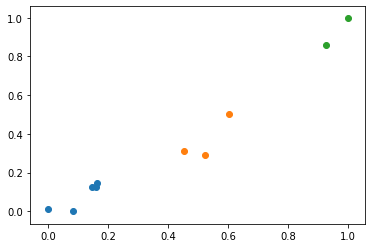

[2 1 1 0 2 0 0 2 0 0]
[[4.76290173e-14 0.00000000e+00 1.00000000e+00]
 [3.77479527e-40 1.00000000e+00 4.13899075e-11]
 [1.92190750e-51 1.00000000e+00 1.11779289e-14]
 [1.00000000e+00 0.00000000e+00 5.70942368e-13]
 [2.39347299e-13 0.00000000e+00 1.00000000e+00]
 [1.00000000e+00 0.00000000e+00 3.54734278e-24]
 [1.00000000e+00 0.00000000e+00 9.25128125e-13]
 [3.72641286e-07 0.00000000e+00 9.99999627e-01]
 [1.00000000e+00 0.00000000e+00 1.75249812e-14]
 [1.00000000e+00 0.00000000e+00 6.61521697e-14]]


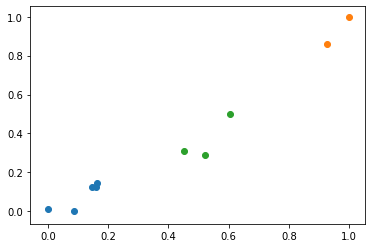

In [153]:
# Cluster data with normalized features
from sklearn.cluster import KMeans
def cluster_data(features, n_clusters):
    #print(features)
    features = np.array(features).T
    kmeans = KMeans(n_clusters=n_clusters).fit(features)
    return kmeans

n_clusters=3
cluster_features = [features[0], features[5]]
cluster_features = normalize_features(cluster_features)

kmeans = cluster_data(cluster_features, n_clusters)
print(kmeans.labels_)

for label in range(n_clusters):
    indices = [i for i, x in enumerate(kmeans.labels_) if int(x) == label]
    freqs = [cluster_features[0][i] for i in indices]
    amounts = [cluster_features[1][i] for i in indices]
    plt.scatter(freqs, amounts, label=str(label))
plt.show()

### Gaussian mixture model
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, covariance_type='full')
gmm_features = np.array(cluster_features).T
labels = gmm.fit_predict(gmm_features)
print(labels)
probs = gmm.predict_proba(gmm_features)
print(probs)
for label in range(n_clusters):
    indices = [i for i, x in enumerate(labels) if int(x) == label]
    freqs = [cluster_features[0][i] for i in indices]
    amounts = [cluster_features[1][i] for i in indices]
    plt.scatter(freqs, amounts, label=str(label))
plt.show()



